In [527]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDRegressor

In [528]:
df = pd.read_csv("life_tables_master.csv")
df

,Unnamed: 0,Year,Demographic,Sex,Age Range,q(x),l(x),d(x),L(x),T(x),e(x)
0,0,2001,total,total,0-1,0.006842,100000.000000,684.164368,99404.093750,7.696164e+06,76.961647
1,1,2001,total,total,1-2,0.000524,99315.835938,52.007931,99289.828125,7.596760e+06,76.490929
2,2,2001,total,total,2-3,0.000337,99263.828125,33.418362,99247.117188,7.497470e+06,75.530739
3,3,2001,total,total,3-4,0.000252,99230.406250,24.965801,99217.921875,7.398224e+06,74.556015
4,4,2001,total,total,4-5,0.000208,99205.437500,20.636427,99195.125000,7.299006e+06,73.574654
...,...,...,...,...,...,...,...,...,...,...,...
15382,15382,2017,black,female,96–97,0.206800,9515.080078,1967.715576,8531.222656,3.304413e+04,3.472817
15383,15383,2017,black,female,97–98,0.223822,7547.364258,1689.269409,6702.729492,2.451291e+04,3.247877
15384,15384,2017,black,female,98–99,0.241511,5858.094727,1414.791504,5150.699219,1.781018e+04,3.040268
15385,15385,2017,black,female,99–100,0.259776,4443.303223,1154.265625,3866.170410,1.265948e+04,2.849114


**Feature Engineering**

In [529]:
# remove "Unnamed: 0" col
df = df.drop(columns = ["Unnamed: 0"])

In [530]:
# remove "total" sex/demographic rows
df = df[df["Sex"] != "total"]
df = df[df["Demographic"] != "total"]

In [531]:
# turn Age Range into scalar based on the lower number in the range:
# 1-2 becomes 1; "100 and over" becomes 100z
def parseAge(x):
    group = x
    if type(group) == str:
        ind_dash = group.find("-")
        ind_hyph = group.find("–")
        if ind_dash < 0 and ind_hyph < 0:
            lower = 100
        elif ind_dash >= 0:
            lower = group[0:ind_dash]
        else:
            lower = group[0:ind_hyph]
        return lower
    return -1


df["Adjusted Age"] = df["Age Range"].apply(lambda x: parseAge(x))

df = df.drop(columns = ["Age Range"])

df

,Year,Demographic,Sex,q(x),l(x),d(x),L(x),T(x),e(x),Adjusted Age
404,2001,white,male,0.006209,100000.000000,620.944458,99455.429688,7.487210e+06,74.872108,0
405,2001,white,male,0.000510,99379.054688,50.704689,99353.703125,7.387755e+06,74.339157,1
406,2001,white,male,0.000360,99328.351562,35.738022,99310.484375,7.288402e+06,73.376846,2
407,2001,white,male,0.000266,99292.617188,26.367809,99279.437500,7.189091e+06,72.403076,3
408,2001,white,male,0.000223,99266.250000,22.169086,99255.164062,7.089812e+06,71.422173,4
...,...,...,...,...,...,...,...,...,...,...
15382,2017,black,female,0.206800,9515.080078,1967.715576,8531.222656,3.304413e+04,3.472817,96
15383,2017,black,female,0.223822,7547.364258,1689.269409,6702.729492,2.451291e+04,3.247877,97
15384,2017,black,female,0.241511,5858.094727,1414.791504,5150.699219,1.781018e+04,3.040268,98
15385,2017,black,female,0.259776,4443.303223,1154.265625,3866.170410,1.265948e+04,2.849114,99


In [532]:
# one-hot encode demographics and sex
demographics = pd.get_dummies(df.Demographic, prefix='Demographic')
sex = pd.get_dummies(df.Sex)
df["Is White"] = demographics["Demographic_white"]
df["Is Male"] = sex["male"]
df = df.drop(columns = ["Demographic", "Sex"])
df

,Year,q(x),l(x),d(x),L(x),T(x),e(x),Adjusted Age,Is White,Is Male
404,2001,0.006209,100000.000000,620.944458,99455.429688,7.487210e+06,74.872108,0,1,1
405,2001,0.000510,99379.054688,50.704689,99353.703125,7.387755e+06,74.339157,1,1,1
406,2001,0.000360,99328.351562,35.738022,99310.484375,7.288402e+06,73.376846,2,1,1
407,2001,0.000266,99292.617188,26.367809,99279.437500,7.189091e+06,72.403076,3,1,1
408,2001,0.000223,99266.250000,22.169086,99255.164062,7.089812e+06,71.422173,4,1,1
...,...,...,...,...,...,...,...,...,...,...
15382,2017,0.206800,9515.080078,1967.715576,8531.222656,3.304413e+04,3.472817,96,0,0
15383,2017,0.223822,7547.364258,1689.269409,6702.729492,2.451291e+04,3.247877,97,0,0
15384,2017,0.241511,5858.094727,1414.791504,5150.699219,1.781018e+04,3.040268,98,0,0
15385,2017,0.259776,4443.303223,1154.265625,3866.170410,1.265948e+04,2.849114,99,0,0


In [533]:
# yr = MinMaxScaler().fit(df).transform(df["Year"])
# yr

min_year = min(df["Year"])
name = "Years Since " + str(min_year)

df[name] = df["Year"] - min_year
df = df.drop(columns = ["Year"])
df

,q(x),l(x),d(x),L(x),T(x),e(x),Adjusted Age,Is White,Is Male,Years Since 2001
404,0.006209,100000.000000,620.944458,99455.429688,7.487210e+06,74.872108,0,1,1,0
405,0.000510,99379.054688,50.704689,99353.703125,7.387755e+06,74.339157,1,1,1,0
406,0.000360,99328.351562,35.738022,99310.484375,7.288402e+06,73.376846,2,1,1,0
407,0.000266,99292.617188,26.367809,99279.437500,7.189091e+06,72.403076,3,1,1,0
408,0.000223,99266.250000,22.169086,99255.164062,7.089812e+06,71.422173,4,1,1,0
...,...,...,...,...,...,...,...,...,...,...
15382,0.206800,9515.080078,1967.715576,8531.222656,3.304413e+04,3.472817,96,0,0,16
15383,0.223822,7547.364258,1689.269409,6702.729492,2.451291e+04,3.247877,97,0,0,16
15384,0.241511,5858.094727,1414.791504,5150.699219,1.781018e+04,3.040268,98,0,0,16
15385,0.259776,4443.303223,1154.265625,3866.170410,1.265948e+04,2.849114,99,0,0,16


In [534]:
df = df.dropna(axis = 0)
df

,q(x),l(x),d(x),L(x),T(x),e(x),Adjusted Age,Is White,Is Male,Years Since 2001
404,0.006209,100000.000000,620.944458,99455.429688,7.487210e+06,74.872108,0,1,1,0
405,0.000510,99379.054688,50.704689,99353.703125,7.387755e+06,74.339157,1,1,1,0
406,0.000360,99328.351562,35.738022,99310.484375,7.288402e+06,73.376846,2,1,1,0
407,0.000266,99292.617188,26.367809,99279.437500,7.189091e+06,72.403076,3,1,1,0
408,0.000223,99266.250000,22.169086,99255.164062,7.089812e+06,71.422173,4,1,1,0
...,...,...,...,...,...,...,...,...,...,...
15382,0.206800,9515.080078,1967.715576,8531.222656,3.304413e+04,3.472817,96,0,0,16
15383,0.223822,7547.364258,1689.269409,6702.729492,2.451291e+04,3.247877,97,0,0,16
15384,0.241511,5858.094727,1414.791504,5150.699219,1.781018e+04,3.040268,98,0,0,16
15385,0.259776,4443.303223,1154.265625,3866.170410,1.265948e+04,2.849114,99,0,0,16


**Split into training (80%), validation (10%), and testing (10%) sets.**

In [535]:
y = df['e(x)']
X = df.drop(columns=['e(x)'])

In [536]:
# using scikit learn package - it only splits into train and test, so make a tmp test set and then split 
# that set in half for a validation set 
X_train, X_test_tmp, y_train, y_test_tmp = train_test_split(X, y, test_size=0.2)

X_valid, X_test, y_valid, y_test = train_test_split(X_test_tmp, y_test_tmp, test_size=0.5)

**Create a linear regression and evaluate its accuracy use MSE on the validation set.**

In [537]:
LR = LinearRegression().fit(X_train, y_train)
lr_preds = LR.predict(X_valid)
lr_MSE = mean_squared_error(y_valid, lr_preds)
lr_MSE

0.1100227618049457

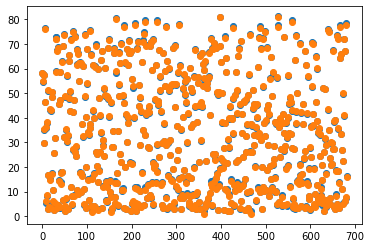

In [538]:
x_axis = range(len(y_valid))
plt.scatter(x_axis, y_valid)
plt.scatter(x_axis, lr_preds)

**Create a stochastic gradient descent regression and evaluate its accuracy use MSE on the validation set.**

In [539]:
SGD = SGDRegressor(max_iter=1000, tol=1e-3).fit(X_train, y_train)
sgd_preds = SGD.predict(X_valid)
sgd_MSE = mean_squared_error(y_valid, sgd_preds)
sgd_MSE

7.870237396715476e+43

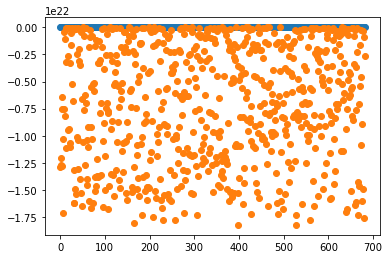

In [541]:
x_axis = range(len(y_valid))
plt.scatter(x_axis, y_valid)
plt.scatter(x_axis, sgd_preds)